In [ ]:
!pip install scikit-learn textblob wordcloud vaderSentiment gensim



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 64.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df = pd.read_csv('/content/drive/MyDrive/WRIT20833/Data/SupermanReturns.csv', encoding='latin1')
df.head()


,Rating(/10),Review Title,Review,Helpful Upvotes,Helpful Downvotes,Username,Date,Contains Spoiler
0,10.0,"In the 28 known galaxies, there is no better film",I just caught a screener and am so blown away....,435.0,441.0,davidsimmons,"Jun 17, 2006",NaN
1,8.0,Superman Returns: The Official Review (spoiler...,NaN,308.0,297.0,MLFILMS,"Jun 17, 2006",Spoiler
2,7.0,A different story on a classic superhero.,Brandon Routh does pull it off as the new Clar...,30.0,34.0,missportillo,"Jun 17, 2006",NaN
3,6.0,Superman Returns,NaN,16.0,34.0,Blood_Storm,"Jun 17, 2006",Spoiler
4,10.0,The Man Of Steel is back....,and from the looks of this movie and how much ...,291.0,304.0,S_Forgel,"Jun 18, 2006",NaN


In [14]:
df.columns = df.columns.str.strip()
df.columns


Index(['Rating(/10)', 'Review Title', 'Review', 'Helpful Upvotes',
       'Helpful Downvotes', 'Username', 'Date', 'Contains Spoiler'],
      dtype='object')

In [15]:
df.rename(columns={'Review': 'review'}, inplace=True)


In [16]:
df['review'].head()


,review
0,I just caught a screener and am so blown away....
1,NaN
2,Brandon Routh does pull it off as the new Clar...
3,NaN
4,and from the looks of this movie and how much ...


In [17]:
df = df.dropna(subset=['review'])
df.shape


(1098, 8)

In [18]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()
    text = "".join([c for c in text if c not in string.punctuation])
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['clean_review'] = df['review'].apply(clean_text)
df.head()


/tmp/ipython-input-4056356770.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_review'] = df['review'].apply(clean_text)


,Rating(/10),Review Title,review,Helpful Upvotes,Helpful Downvotes,Username,Date,Contains Spoiler,clean_review
0,10.0,"In the 28 known galaxies, there is no better film",I just caught a screener and am so blown away....,435.0,441.0,davidsimmons,"Jun 17, 2006",NaN,caught screener blown away original came 6 fan...
2,7.0,A different story on a classic superhero.,Brandon Routh does pull it off as the new Clar...,30.0,34.0,missportillo,"Jun 17, 2006",NaN,brandon routh pull new clark kentsuperman movi...
4,10.0,The Man Of Steel is back....,and from the looks of this movie and how much ...,291.0,304.0,S_Forgel,"Jun 18, 2006",NaN,looks movie much making im sure hes back goodo...
5,7.0,This film does for Superman what Batman Begins...,"Of all the Superheroes, my favorite has always...",39.0,51.0,HiddenVoice,"Jun 19, 2006",NaN,superheroes favorite always batman spidermanal...
6,10.0,greatest super hero film ever,Brandon Routh perfectly portrays both Clark Ke...,26.0,31.0,mct1115,"Jun 20, 2006",NaN,brandon routh perfectly portrays clark kent su...


In [19]:
df = df.dropna(subset=['review']).copy()
df['clean_review'] = df['review'].apply(clean_text)


In [20]:
sid = SentimentIntensityAnalyzer()

df['vader_score'] = df['clean_review'].apply(
    lambda x: sid.polarity_scores(x)['compound']
)


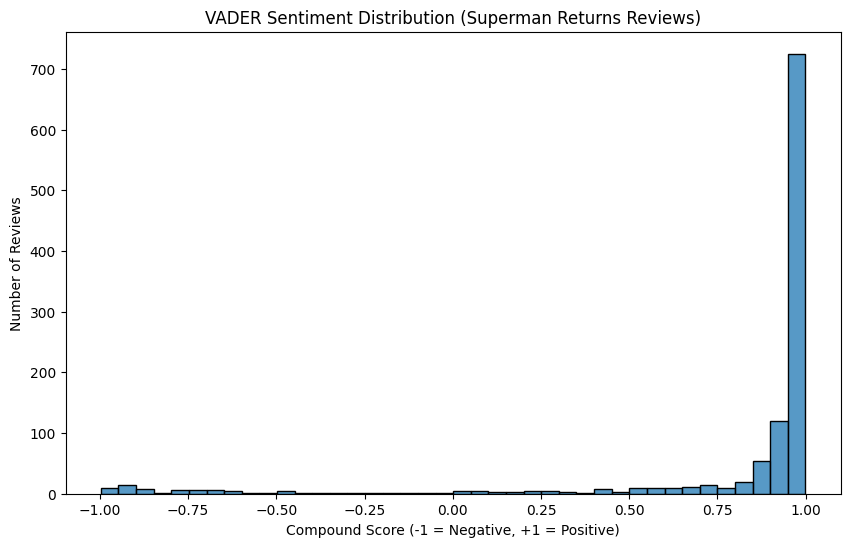

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(df['vader_score'], bins=40, kde=False)
plt.title("VADER Sentiment Distribution (Superman Returns Reviews)")
plt.xlabel("Compound Score (-1 = Negative, +1 = Positive)")
plt.ylabel("Number of Reviews")
plt.show()


In [22]:
df['tb_polarity'] = df['clean_review'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)


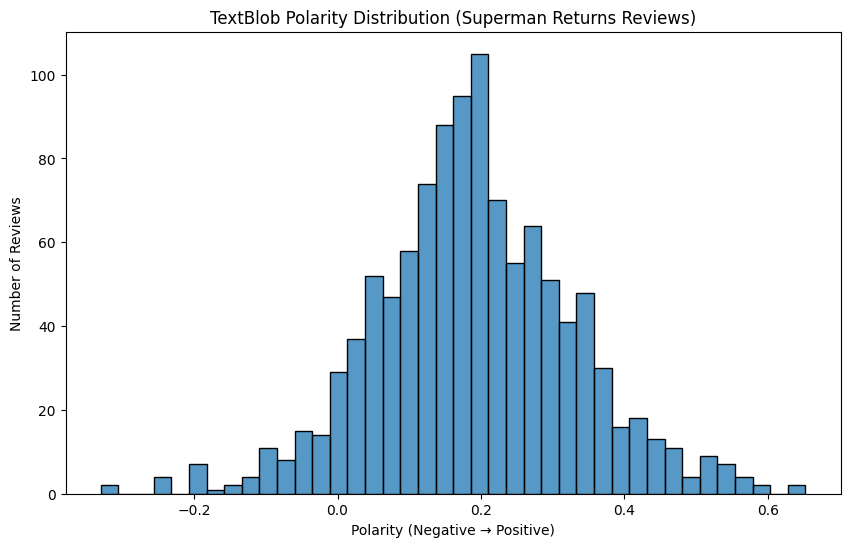

In [23]:
plt.figure(figsize=(10,6))
sns.histplot(df['tb_polarity'], bins=40, kde=False)
plt.title("TextBlob Polarity Distribution (Superman Returns Reviews)")
plt.xlabel("Polarity (Negative → Positive)")
plt.ylabel("Number of Reviews")
plt.show()


In [24]:
vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(df['clean_review'])
word_counts = X.toarray().sum(axis=0)

tf_df = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'count': word_counts
}).sort_values(by='count', ascending=False)

tf_df


,word,count
26,superman,4394
15,movie,3250
6,film,1723
12,like,1131
13,lois,973
7,good,952
8,great,935
22,routh,833
21,returns,812
11,lex,801


In [25]:
cv = CountVectorizer(stop_words='english')
dtm = cv.fit_transform(df['clean_review'])


In [26]:
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)


LatentDirichletAllocation(n_components=3, random_state=42)

In [27]:
def show_topics(model, feature_names, n_top_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
        topics.append(words)
    return topics

topics = show_topics(lda, cv.get_feature_names_out())
topics


[['superman',
  'film',
  'lois',
  'returns',
  'singer',
  'world',
  'lex',
  'luthor',
  'lane',
  'character'],
 ['superman',
  'movie',
  'film',
  'like',
  'good',
  'great',
  'routh',
  'movies',
  'lois',
  'lex'],
 ['superman',
  'film',
  'movie',
  'story',
  'like',
  'lois',
  'singer',
  'world',
  'clark',
  'time']]

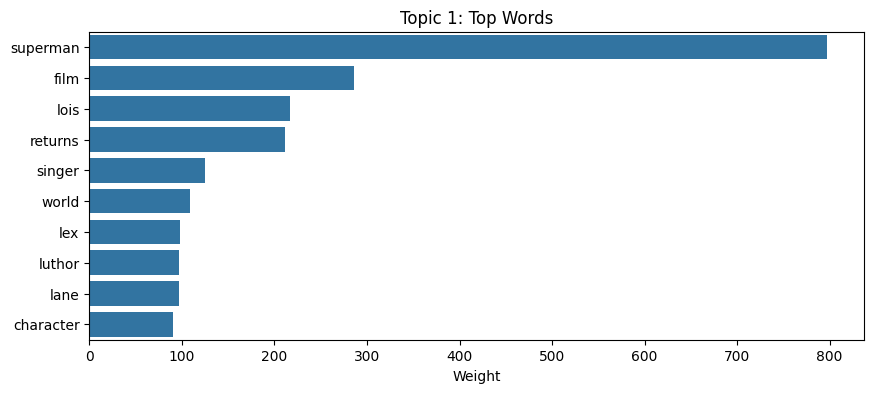

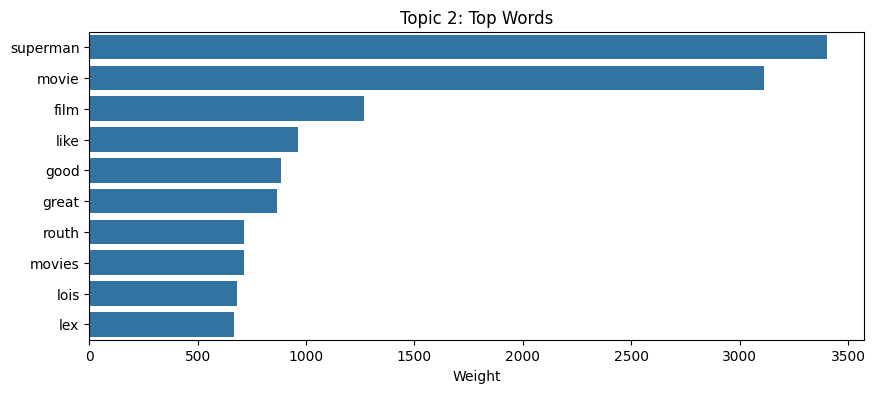

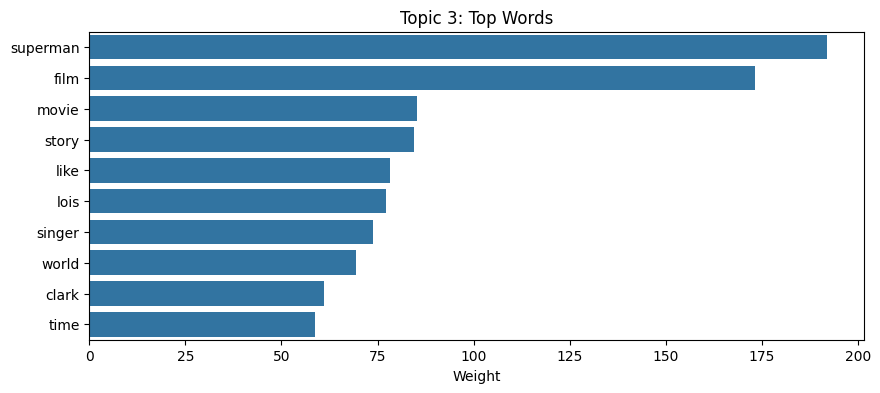

In [28]:
for i, topic in enumerate(topics):
    counts = lda.components_[i]
    idx = counts.argsort()[-10:][::-1]
    words = [cv.get_feature_names_out()[j] for j in idx]
    weights = counts[idx]

    plt.figure(figsize=(10,4))
    sns.barplot(x=weights, y=words)
    plt.title(f"Topic {i+1}: Top Words")
    plt.xlabel("Weight")
    plt.show()


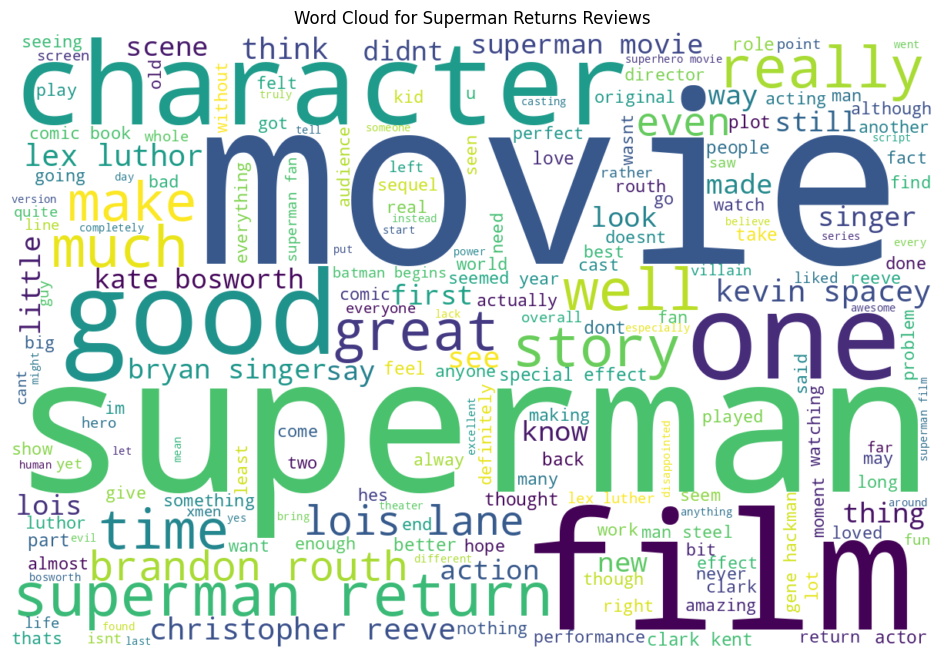

In [29]:
text = " ".join(df['clean_review'])

wc = WordCloud(width=1200, height=800, background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Superman Returns Reviews")
plt.show()
